# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from hrv_utils.utils import read_file
from scipy.signal import savgol_filter

# Detrended Fluctuation Analysis (DFA)

Detrended fluctuation analysis (DFA) is a method for determining the statistical self-affinity of a signal, and is useful for analysing series that appear to be long-memory processes. It produces an exponent similar to the Hurst one, with the advantage of being applicable even in non-stationary series. Let's start by defining what even is a long-memory process.

Long-memory processes, also known as long-range dependent processes, describes a specific characteristic of the rate of decay of the statistical dependence of two points with increasing time in some signals. Processes with long-memory are often related to self-similar processes, and are typically defined as signals to which the long-range dependence dacays slower than an exponential decay. This can be determined for example by analysing the power spectral density (PSD) of a signal, as it is directly related to the Autocorrelation function via the Fourier Transform.

When we have our PSD in log-log scales, a linear variation indicates a polynomial trend, which is slower than the exponential case. Thus, if our PSD presents a linear decay in log-log scales it corresponds to long-memory process. On the other hand, if the model presents a linear increase of the PSD with frequency it has what is called anti-persistence. This can be understood when analysing the spectral density by taking a look at the frequencies. When our PSD decays linearly, it means the main components in our signal are of low frequency. This in turn signifies that our signal tends to have longer trends and tends to take longer to vary, such that values close in time tend to be close as well. This classifies the long-memory, as it means that past values of the process have a substantial influence on future values, even if they are far apart in time.. On the other hand, if the power increases with the frequencies, it means that the main components in our signal will be the really high frequencies, which are characterized by fast variation. This leads to points tending to be followed by a value that is opposite in sign or direction, in what is called anti-persistance, negative memory or negative autocorrelation.

This can all be associated with the Hurst exponent H as well. For H = $\frac{1}{2}$ we have the absence of long-range dependence. On the other hand, $\frac{1}{2} < H < 1$ indicates long-term persitance, with higher H being associated with higher long-range dependence. On the other hand, $0 < H < \frac{1}{2}$ indicates anti-persistance, meaning strong negative correlation and large fluctuations.

As was discussed before, it is possible to extract information about the process memory from the PSD, however these and some other approaches have the huge drawback that they are not applicable to non-stationary series. To overcome this, Dentrended Fluctuation Analysis (DFA) was proposed. DFA is an automatic methods that permits the detection of long-range correlations embedded in a patchy landscape, while also avoiding the spurious detection of apparent long-range correlations that are an artifact of patchiness and non-stationarity.

The algorithm for DFA is as follows:

1. Subtract the average of the signal (x(t) = signal - $\langle signal \rangle$)
2. Integrate the signal (y(t) = $\sum_{i=0}^t x(t)$)
3. For a given scale s:
    * Divide the integrate signal into N nonoverlapping segments of length s
    * Compute the local trend of each of the segments by fitting a polynomial to the data ($\hat{y}(t)$)
    * Subtract the polynomial fit from the original data ($e(t) = y(t) - \hat{y}(t)$)
    * Compute the variance of e(t) for each segment ($F^2(s) = \frac{1}{s} \sum_{i=0}^s e(i)^2$)
    * Calculate the q-th order fluctuation function $F_q(s)=\{\frac{1}{N}\sum F^2(s)^{q/2}\}^{1/q}$
    * Repeat over many values of s
4. Plot $F_q$ as a function of s in log-log scale
5. Analyze scaling behaviour (usually by fitting a line on the data).

In case the data cannot be exactly divided into the desired number of segments, you can repeat the process with the segments starting backwards as well as forwards, which results in double the number of blocks.

Text(0, 0.5, '$F_q$')

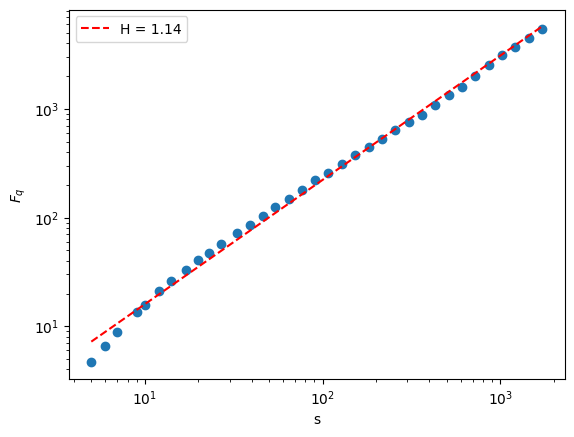

In [17]:
fs = 4
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate=fs,
)

# Step 1: Subtract the mean
x = hrv - np.mean(hrv)

# Step 2: Integrate the data
y = np.cumsum(hrv)

# Step 3: Compute fluctuation for different scales
scales = np.unique(np.array([1+int(2**(i/4)) for i in range(8, 44)]))
results = []

for s in scales:
    # Step 3.1: Divide series into non-overlapping segments of length s
    N = len(y)//s
    segments = np.array(np.split(y[:N*s], N))

    # Step 3.2: Fit polynomial to each segment
    order = 1 # Here I am using a 1st order polynomial, meaning it's just a line
    t = np.linspace(0, s/fs, s)
    coefs = np.polynomial.polynomial.polyfit(t, segments.T, order, full=False)
    estimation = np.polynomial.polynomial.polyval(t, coefs)

    # Step 3.3: Compute the difference between the original and the polynomial fit
    e = segments-estimation

    # Step 3.4: Calculate the variance of each segment
    F = np.mean(e**2, axis=1)

    # Step 3.5: Compute the fluctuation function
    q = 2 # Note that for q=2 this is nothing more than the root of the average
    Fq = np.mean(F**(q/2))**(1/q)
    results.append(Fq)
    
# Step 4: Plot the results in log-log scale
plt.scatter(scales, results)
plt.xscale('log')
plt.yscale('log')

# Step 5: Analyze data by fitting line to it
H, intercept = np.polyfit(np.log10(scales), np.log10(results), 1)
line = H*np.log10(scales)+intercept
plt.plot(scales, np.power(10, line), 'r--', label=f"H = {H:.2f}")

plt.legend()
plt.xlabel("s")
plt.ylabel(r"$F_q$")

Note that, for series where only short-range correlations (or no correlations) exist, the detrended signal must have the statistical properties of a random walk (unbiased or biased) so $F_d(s) \sim s^{1/2}$ however, if there is long-range power-law correlation (i.e., no characteristic length scale), then $F_d(s) \sim s^\alpha$ with $\alpha \neq \frac{1}{2}$. This exponent $\alpha$ actually describes the scaling properties of the entire distribution and not only of $F_d(s)$.

Once again there are python packages that already perform this calculations, such as fathon.

# Detrended Moving Averages Analysis (DMA)

DFA has been used in many different applications throught the years, demonstrating its importance. However, there are a few improvements that can still be made to it. Firstly, the fluctuations in the DFA tend to present quite a bit of jitter in many practical applications, which can make the analysis more complicated. More than that, the fact that the detrending is being done via piecewise polynomial functions means that it is not a linear operation, which violates the reproducibility principles.

Meet the Detrended Moving Average Analysis (DMA). It was developed in such a way that it accounts for both these drawbacks in the DFA, resulting in smoother curves and still ensuring the reproducibility by making use of linear operations.

The DMA procedure is very similar to what was done before in the DFA, with the main difference being that instead of fitting piecewise polynomials we apply moving average polynomials to our signal. This was shown to be equivalent to applying a Savitzky-Golay filter to the data. With this, de procedure for a signal of length N becomes as follows:

1. Subtract the average of the signal (x(t) = signal - $\langle signal \rangle$)
2. Integrate the signal (y(t) = $\sum_{i=0}^t x(t)$)
3. For a given scale s:
    * Apply a savitzky-golay filter with window size s to the data ($\hat{y}(t)$). The polynomial order is arbitrary by the user, but usually 0, 2 or at most 4.
    * Subtract the polynomial fit from the original data ($e(t) = y(t) - \hat{y}(t)$)
    * Compute the generalized variance defined as $\sigma_{DMA}^2(s) = \frac{1}{N-s}\sum_i e(t)^2$. Note that this sum goes from $1+\frac{s-1}{2} \leq s \leq N-\frac{s-1}{2}$
    * Repeat over many values of s
4. Plot $\sigma_{DMA}^2(s)$ in log-log scale
5. Analyze scaling behaviour (usually by fitting a line on the data).

Text(0, 0.5, '$\\sigma_{DMA}$')

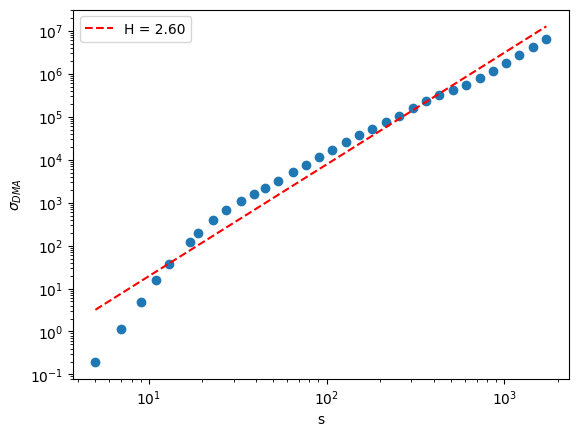

In [3]:
fs = 4
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate=fs,
)

# Step 1: Subtract the mean
x = hrv - np.mean(hrv)

# Step 2: Integrate the data
y = np.cumsum(hrv)

# Step 3: Compute fluctuation for different scales
scales = np.unique(np.array([1+int(2**(i/4)/2)*2 for i in range(8, 44)]))
results = []

for s in scales:
    # Step 3.1: Apply savitzky-golay to data
    order = 2
    estimation = savgol_filter(y, s, order)

    # Step 3.2: Compute the difference between the original and the polynomial fit
    e = y-estimation

    # Step 3.3: Calculate the generalized variance
    sigma = np.mean((e**2)[(s-1)//2: -(s-1)//2])
    results.append(sigma)
    
# Step 4: Plot the results in log-log scale
plt.scatter(scales, results)
plt.xscale('log')
plt.yscale('log')

# Step 5: Analyze data by fitting line to it
H, intercept = np.polyfit(np.log10(scales), np.log10(results), 1)
line = H*np.log10(scales)+intercept
plt.plot(scales, np.power(10, line), 'r--', label=f"H = {H:.2f}")

plt.legend()
plt.xlabel("s")
plt.ylabel(r"$\sigma_{DMA}$")

Notice how the data actually appears to present two different trends, one in the lower scales and one in the higher ones. When this is the case, it is common to fit the line only for the last linear part of the data, as follows. One way to try to do this would be to simply disconsider the first few points when fitting the line.

Text(0, 0.5, '$\\sigma_{DMA}$')

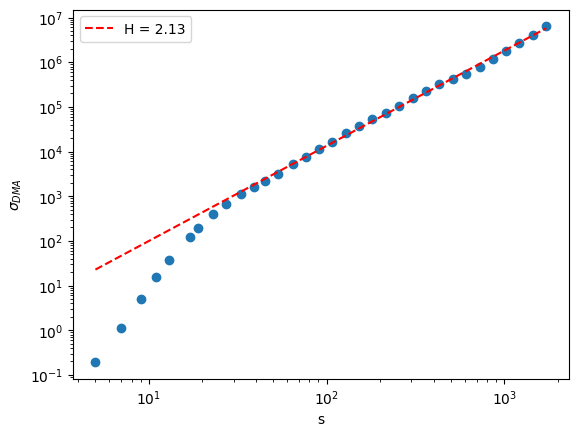

In [4]:
plt.scatter(scales, results)
plt.xscale('log')
plt.yscale('log')

H, intercept = np.polyfit(np.log10(scales)[10:], np.log10(results)[10:], 1)
line = H*np.log10(scales)+intercept
plt.plot(scales, np.power(10, line), 'r--', label=f"H = {H:.2f}")

plt.legend()
plt.xlabel("s")
plt.ylabel(r"$\sigma_{DMA}$")

Now, this is all good already, but unfortunately this direct computation of the DMA is really computationally expensive. Luckily, through some programming optimizations and matehmatical approximations it is possible to severely speed up the computation. The details of how that work are besides the scope of this explanation, but the reader can refer to "Fast algorithm for scaling analysis with higher-order detrending moving average method" by Tsujimoto Y., Kiyono K, et al. In this repository I offer a fast implementation using Cython of the proposed algorithm that achieves performances equivalent to the original C implementation. Below is an example of it.

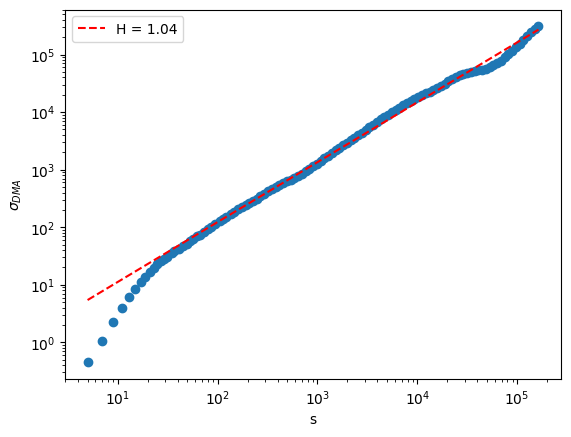

In [8]:
from hrv_utils.dma import dma, create_scales

fs = 4
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate=fs,
)

scales = create_scales(5, len(hrv)//2)
order = 2
coefs = dma(hrv, scales, order)

plt.scatter(scales, coefs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("s")
plt.ylabel(r"$\sigma_{DMA}$")

H, intercept = np.polyfit(np.log10(scales[15:]), np.log10(coefs[15:]), 1)
line = H*np.log10(scales)+intercept
plt.plot(scales, np.power(10, line), 'r--', label=f"H = {H:.2f}")

plt.legend()

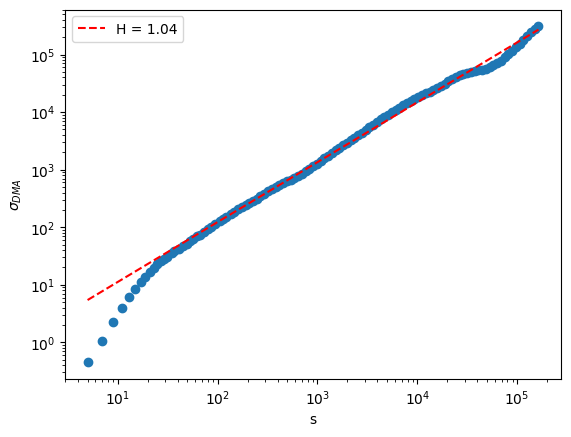

In [2]:
from hrv_utils.dma import dma, create_scales

fs = 4
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate=fs,
)

scales = create_scales(5, len(hrv)//2)
order = 2
coefs = dma(hrv, scales, order, q=2)

plt.scatter(scales, coefs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("s")
plt.ylabel(r"$\sigma_{DMA}$")

H, intercept = np.polyfit(np.log10(scales[15:]), np.log10(coefs[15:]), 1)
line = H*np.log10(scales)+intercept
plt.plot(scales, np.power(10, line), 'r--', label=f"H = {H:.2f}")

plt.legend()

# Further Readings

For more information about DFA, you can refer to the original paper that proposed it "Mosaic organization of DNA nucleotides" by Peng et al.. For more details about DMA refer to "Self-similarity of higher-order moving averages" by Arianos, S. et al.